# Recurrent Neural Networks - IMDB Movie Reviews

In this exercise, we'll train LSTM models for sentiment classification on the IMDB dataset. We'll compare two embedding approaches:
1. **Trainable Embeddings**: Using Keras Embedding layer (learned during training)
2. **Pre-trained Embeddings**: Using GloVe word vectors (transfer learning)

**Dataset**: IMDB Movie Review Sentiment Classification from [keras.datasets](https://keras.io/api/datasets/imdb/)  
**Task**: Binary classification (positive/negative sentiment)  
**Architecture**: LSTM (Long Short-Term Memory) Recurrent Neural Network

## 1. Setup and Imports

In [1]:
import numpy as np
import keras
from utils import (
    load_imdb_data,
    create_embedding_matrix_from_glove,
    download_glove_embeddings,
    create_lstm_model_with_embedding,
    train_model,
    eval_binary_classification,
    compare_models,
    plot_training_history
)

In [2]:
# Hyperparameters
MAX_WORDS = 10000      # Vocabulary size
MAX_LEN = 500          # Maximum sequence length
EMBEDDING_DIM = 100    # Embedding dimension (must match GloVe file)
LSTM_UNITS = 100       # LSTM hidden units
BATCH_SIZE = 64
EPOCHS = 10

## 2. Load IMDB Dataset

We use `keras.datasets.imdb` which provides pre-processed movie reviews. The dataset contains 25,000 training and 25,000 test reviews, labeled by sentiment (positive/negative).

In [3]:
# Load data using keras.datasets.imdb
# This splits the original test set into validation (50%) and hold-out test (50%)
X_train, y_train, X_val, y_val, X_test, y_test, word_index = load_imdb_data(
    num_words=MAX_WORDS,
    maxlen=MAX_LEN,
    test_split=0.5
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training samples:   25,000
Validation samples: 12,500
Test samples:       12,500
Vocabulary size:    10,000
Sequence length:    500


In [4]:
# Inspect the data shape
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nFirst training sample (word indices):")
print(X_train[0][:50], "...")

X_train shape: (25000, 500)
y_train shape: (25000,)

First training sample (word indices):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [5]:
# Decode a sample review to see what the text looks like
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<OOV>'

def decode_review(encoded):
    return ' '.join(reverse_word_index.get(i, '<?>') for i in encoded if i != 0)

print("Sample review:")
print(decode_review(X_train[0])[:500], "...")
print(f"\nLabel: {'Positive' if y_train[0] == 1 else 'Negative'}")

Sample review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would re ...

Label: Positive


## 3. Model 1: LSTM with Trainable Embeddings

First, we train an LSTM with a trainable `Embedding` layer that learns word representations from scratch during training.

In [6]:
# Create LSTM model with trainable embeddings
model_trainable = create_lstm_model_with_embedding(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LEN,
    lstm_units=LSTM_UNITS,
    embedding_matrix=None,  # No pre-trained embeddings
    trainable_embeddings=True
)

model_trainable.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,501 (4.12 MB)

 Trainable params: 1,080,501 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
model_trainable, history_trainable = train_model(
    model=model_trainable,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="lstm_trainable_embedding",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping=True,
    patience=3
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 281ms/step - accuracy: 0.7908 - loss: 0.4505 - val_accuracy: 0.8597 - val_loss: 0.3490
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 108s 276ms/step - accuracy: 0.8880 - loss: 0.2807 - val_accuracy: 0.8733 - val_loss: 0.3225
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 107s 275ms/step - accuracy: 0.9207 - loss: 0.2129 - val_accuracy: 0.8642 - val_loss: 0.3443
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 282ms/step - accuracy: 0.9410 - loss: 0.1605 - val_accuracy: 0.8643 - val_loss: 0.3723
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 108s 275ms/step - accuracy: 0.9458 - loss: 0.1466 - val_accuracy: 0.8637 - val_loss: 0.4293
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


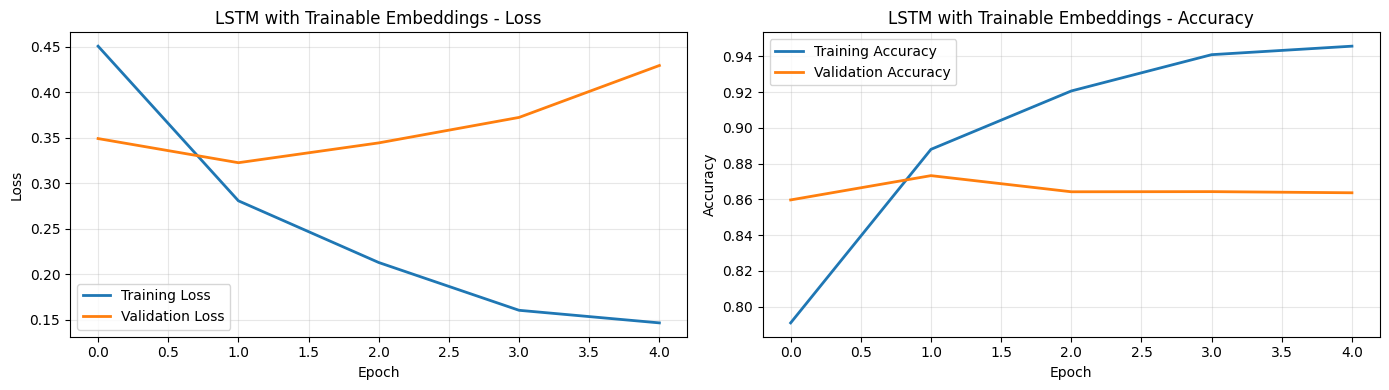

In [8]:
# Plot training history
plot_training_history(history_trainable, title="LSTM with Trainable Embeddings")

## 4. Model 2: LSTM with Pre-trained GloVe Embeddings

Now we use pre-trained GloVe word vectors instead of learning embeddings from scratch. GloVe vectors were trained on a large corpus (Wikipedia + Gigaword) and capture semantic relationships between words.

In [9]:
# Download GloVe embeddings (this may take a while on first run)
glove_path = download_glove_embeddings(glove_dim=EMBEDDING_DIM)

Download complete!
Extracting embeddings...
GloVe embeddings saved to /Users/philippgeppner/.keras/datasets/glove.6B.100d.txt


In [10]:
# Create embedding matrix from GloVe
embedding_matrix = create_embedding_matrix_from_glove(
    glove_path=glove_path,
    word_index=word_index,
    embedding_dim=EMBEDDING_DIM,
    num_words=MAX_WORDS
)

Loading GloVe embeddings from /Users/philippgeppner/.keras/datasets/glove.6B.100d.txt...
Loaded 400,000 word vectors
Matched 9,793 words (98.0% coverage)
Sample missing words: ["else's", "miyazaki's", "victoria's", "paul's", "chan's", "show's", "wife's", "character's", "hadn't", "isn't"]


### Create and Train GloVe Model

We set `trainable_embeddings=False` to freeze the pre-trained embeddings during training (pure transfer learning). You could also set it to `True` to fine-tune the embeddings.

In [11]:
# Create LSTM model with pre-trained GloVe embeddings (frozen)
model_glove = create_lstm_model_with_embedding(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LEN,
    lstm_units=LSTM_UNITS,
    embedding_matrix=embedding_matrix,
    trainable_embeddings=False  # Freeze pre-trained embeddings
)

model_glove.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,501 (4.12 MB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [12]:
# Train the GloVe model
model_glove, history_glove = train_model(
    model=model_glove,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="lstm_glove_embedding",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping=True,
    patience=3
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 242ms/step - accuracy: 0.7252 - loss: 0.5433 - val_accuracy: 0.7623 - val_loss: 0.4957
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 237ms/step - accuracy: 0.8073 - loss: 0.4285 - val_accuracy: 0.8269 - val_loss: 0.3877
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 238ms/step - accuracy: 0.8482 - loss: 0.3500 - val_accuracy: 0.8562 - val_loss: 0.3430
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 234ms/step - accuracy: 0.8688 - loss: 0.3107 - val_accuracy: 0.8227 - val_loss: 0.3797
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 242ms/step - accuracy: 0.8780 - loss: 0.2924 - val_accuracy: 0.8731 - val_loss: 0.2975
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - accuracy: 0.8905 - loss: 0.2666 - val_accuracy: 0.8792 - val_loss: 0.2854
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 246ms/step - accuracy: 0.8962 - loss: 0.2527 - val_accuracy: 0.8843 - val_loss: 0.2800
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 246ms/step - accuracy: 0.9054 - loss: 

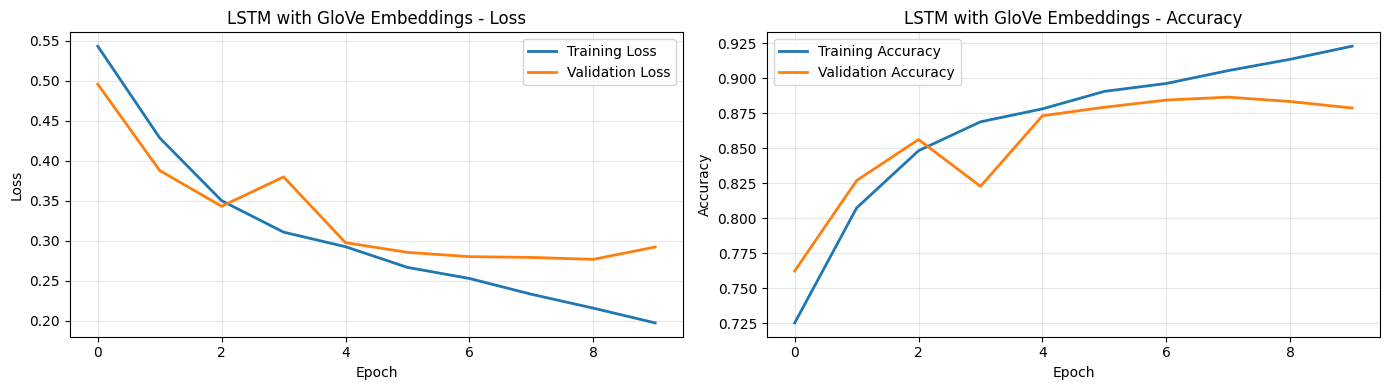

In [13]:
# Plot training history
plot_training_history(history_glove, title="LSTM with GloVe Embeddings")

## 5. Evaluate on Hold-out Test Set

Now we evaluate both models on the hold-out test set to compare their performance.

EVALUATING MODEL 1: LSTM WITH TRAINABLE EMBEDDINGS

  LSTM + Trainable Embeddings - Binary Classification Results
  Test Loss:     0.3074
  Test Accuracy: 0.8801 (88.01%)

              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88      6184
    Positive       0.89      0.87      0.88      6316

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



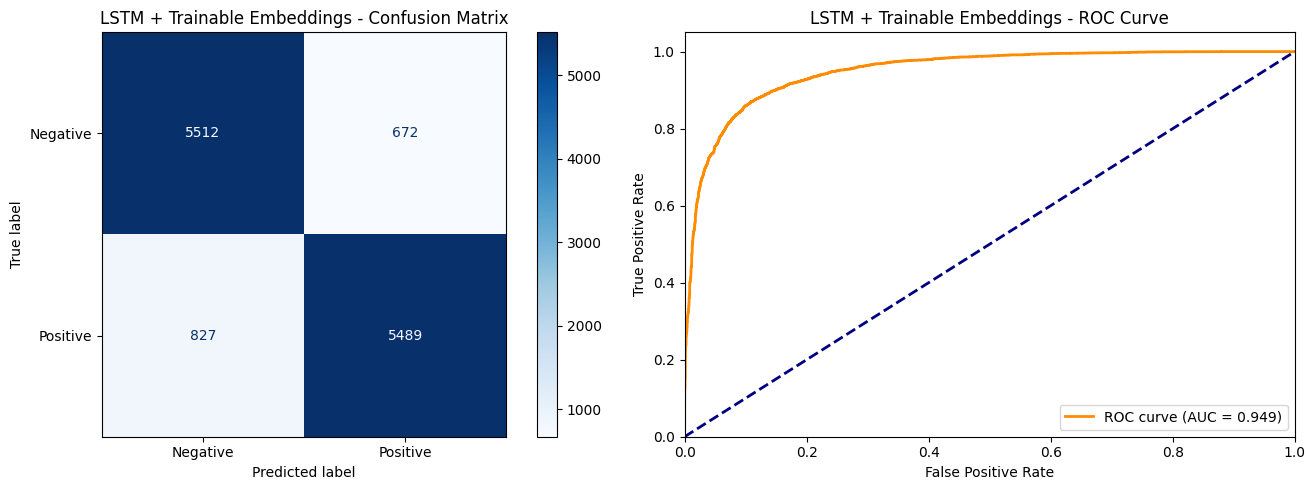

In [14]:
# Evaluate Model 1: Trainable Embeddings
print("=" * 70)
print("EVALUATING MODEL 1: LSTM WITH TRAINABLE EMBEDDINGS")
print("=" * 70)
loss_trainable, acc_trainable = eval_binary_classification(
    model_trainable, X_test, y_test, 
    model_name="LSTM + Trainable Embeddings"
)

EVALUATING MODEL 2: LSTM WITH GLOVE EMBEDDINGS

  LSTM + GloVe Embeddings - Binary Classification Results
  Test Loss:     0.2649
  Test Accuracy: 0.8924 (89.24%)

              precision    recall  f1-score   support

    Negative       0.87      0.92      0.89      6184
    Positive       0.91      0.87      0.89      6316

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



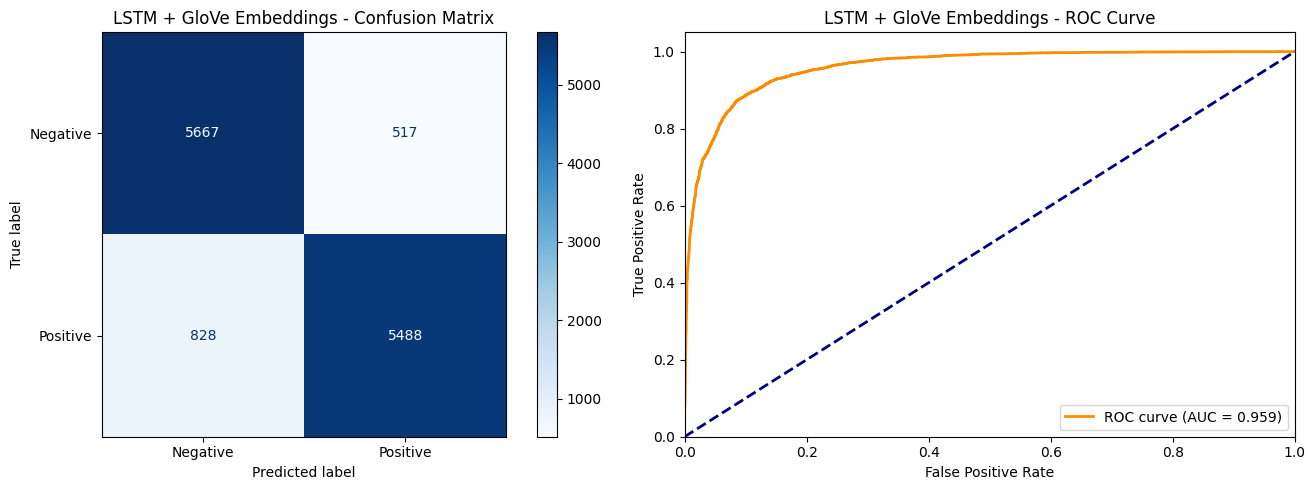

In [15]:
# Evaluate Model 2: GloVe Embeddings
print("=" * 70)
print("EVALUATING MODEL 2: LSTM WITH GLOVE EMBEDDINGS")
print("=" * 70)
loss_glove, acc_glove = eval_binary_classification(
    model_glove, X_test, y_test, 
    model_name="LSTM + GloVe Embeddings"
)

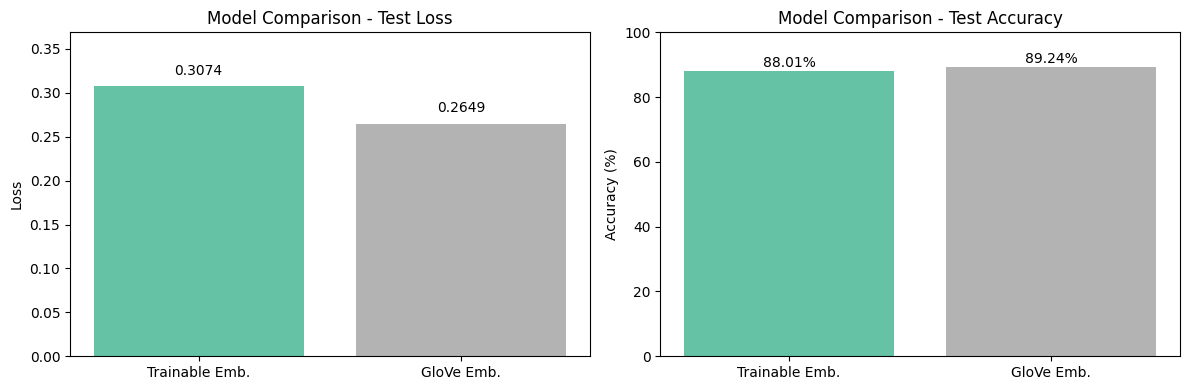

In [16]:
# Compare both models
results = {
    "Trainable Emb.": (loss_trainable, acc_trainable),
    "GloVe Emb.": (loss_glove, acc_glove)
}
compare_models(results)

In [17]:
# Summary table
import pandas as pd
summary_df = pd.DataFrame({
    'Model': ['Trainable Embeddings', 'GloVe Embeddings'],
    'Test Loss': [loss_trainable, loss_glove],
    'Test Accuracy': [f"{acc_trainable*100:.2f}%", f"{acc_glove*100:.2f}%"]
})
summary_df

,Model,Test Loss,Test Accuracy
0,Trainable Embeddings,0.307412,88.01%
1,GloVe Embeddings,0.264877,89.24%


## 6. Test on Custom Reviews

Let's test both models on some custom reviews to see how they perform in practice.

In [28]:
# Custom reviews to test
my_reviews = [
    "this is probably the worst movie i have seen in my entire life it really sucks",
    "great movie wow i really really liked it would highly recommend",
    "it was an incredible experience and i would watch it again without second thought",
    "complete trash show wasted money if you ask me",
    "it was more or less good but nothing special",
    "What a disaster of a movie – a disaster for anyone hoping to dislike it. Witty, captivating, the best of the decade.",
    "A horrible movie – horribly witty and captivating, that is. The defining movie of this decade.",
    "not bad",
    "not not good",
    "enjoyable and thrilling, if you have the brain capacity of a 12 year old teenage boy",
]

# Function to encode a review using the word index
def encode_review(text, word_index, maxlen=500, num_words=10000):
    words = text.lower().split()
    encoded = [1]  # Start token
    for word in words:
        idx = word_index.get(word, 2)  # 2 is OOV
        if idx < num_words - 3:
            encoded.append(idx + 3)  # Shift by 3 for special tokens
        else:
            encoded.append(2)  # OOV
    # Pad/truncate to maxlen
    if len(encoded) < maxlen:
        encoded = [0] * (maxlen - len(encoded)) + encoded
    else:
        encoded = encoded[:maxlen]
    return np.array(encoded)

# Encode all custom reviews
custom_data = np.array([encode_review(r, word_index, MAX_LEN, MAX_WORDS) for r in my_reviews])

# Get predictions from both models
pred_trainable = model_trainable.predict(custom_data, verbose=0).flatten()
pred_glove = model_glove.predict(custom_data, verbose=0).flatten()

# Display results
results_df = pd.DataFrame({
    'Review': [r[:60] + '...' if len(r) > 60 else r for r in my_reviews],
    'Trainable': [f"{'Pos' if p > 0.5 else 'Neg'} ({p:.2f})" for p in pred_trainable],
    'GloVe': [f"{'Pos' if p > 0.5 else 'Neg'} ({p:.2f})" for p in pred_glove]
})
results_df


,Review,Trainable,GloVe
0,this is probably the worst movie i have seen i...,Neg (0.04),Neg (0.01)
1,great movie wow i really really liked it would...,Pos (0.94),Pos (0.99)
2,it was an incredible experience and i would wa...,Pos (0.84),Pos (0.94)
3,complete trash show wasted money if you ask me,Neg (0.07),Neg (0.07)
4,it was more or less good but nothing special,Neg (0.50),Neg (0.20)
5,What a disaster of a movie – a disaster for an...,Neg (0.33),Neg (0.39)
6,A horrible movie – horribly witty and captivat...,Neg (0.18),Neg (0.06)
7,not bad,Neg (0.17),Neg (0.26)
8,not not good,Neg (0.42),Neg (0.38)
9,"enjoyable and thrilling, if you have the brain...",Pos (0.66),Pos (0.90)
